In [ ]:
import io
import os
import random
import shutil
import kagglehub

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.display import display, clear_output
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau  # type: ignore
from tensorflow.keras.layers import Input, Conv2D, Dropout, Flatten, MaxPooling2D, Dense # type: ignore
from tensorflow.keras.models import Sequential, load_model  # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array  # type: ignore


In [ ]:
#https://www.kaggle.com/datasets/orvile/brain-cancer-mri-dataset

In [ ]:
import kagglehub

path = kagglehub.dataset_download("orvile/brain-cancer-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-cancer-mri-dataset


In [ ]:
# Path ke folder berisi brain_glioma, brain_menin, brain_tumor
folder_awal1 = os.path.join(path, "Brain_Cancer raw MRI data")
folder_awal = os.path.join(folder_awal1, "Brain_Cancer")

# Cek apakah benar isi folder_awal sesuai ekspektasi
print("Isi folder_awal:", os.listdir(folder_awal))


Isi folder_awal: ['brain_tumor', 'brain_glioma', 'brain_menin']


In [ ]:

folder_tujuan = 'dataset_classified'  # Folder tujuan untuk struktur baru


split_ratio = {
    'train': 0.7,
    'validation': 0.15,
    'test': 0.15
}

for split in ['train', 'validation', 'test']:
    for class_name in ['brain_glioma', 'brain_menin', 'brain_tumor']:
        os.makedirs(os.path.join(folder_tujuan, split, class_name), exist_ok=True)


In [ ]:
def split_data(class_name, seed):
    class_path = os.path.join(folder_awal, class_name)
    images = os.listdir(class_path)
    random.seed(seed)
    random.shuffle(images)

    total = len(images)
    train_count = int(split_ratio['train'] * total)
    val_count = train_count + int(split_ratio['validation'] * total)

    splits = {
        'train': images[:train_count],
        'validation': images[train_count:val_count],
        'test': images[val_count:]
    }

    for split, files in splits.items():
        for file in files:
            src = os.path.join(class_path, file)
            dst = os.path.join(folder_tujuan, split, class_name, file)
            shutil.copy(src, dst)


In [ ]:
for class_name in ['brain_glioma', 'brain_menin', 'brain_tumor']:
    split_data(class_name, seed=42)

print("Data splitting completed.")

Data splitting completed.


In [ ]:
img_size = (224, 224)
batch_size = 32


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [ ]:
val_test_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
train_generator = train_datagen.flow_from_directory(
    'dataset_classified/train',
    target_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

Found 4237 files belonging to 3 classes.


In [ ]:
val_generator = val_test_datagen.flow_from_directory(
    'dataset_classified/validation',
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

Found 907 files belonging to 3 classes.


In [ ]:
test_generator = val_test_datagen.flow_from_directory(
    'dataset_classified/test',
    target_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=False
)


Found 912 files belonging to 3 classes.


In [ ]:
model = Sequential([
    Input(shape=(*img_size, 3)),

    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(3, activation='softmax')
])


In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)


In [ ]:
earlystop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)


In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)


In [ ]:
callbacks = [checkpoint, earlystop, reduce_lr]


In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=callbacks
)


Epoch 1/15
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.4860 - loss: 10.9782
Epoch 1: val_accuracy improved from -inf to 0.65050, saving model to best_model.keras
133/133 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.4865 - loss: 10.9201 - val_accuracy: 0.6505 - val_loss: 0.7564 - learning_rate: 0.0010
Epoch 2/15
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6635 - loss: 0.7327
Epoch 2: val_accuracy improved from 0.65050 to 0.75524, saving model to best_model.keras
133/133 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.6637 - loss: 0.7324 - val_accuracy: 0.7552 - val_loss: 0.5928 - learning_rate: 0.0010
Epoch 3/15
132/133 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7372 - loss: 0.6247
Epoch 3: val_accuracy improved from 0.75524 to 0.79603, saving model to best_model.keras
133/133 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.7373 - loss: 0.6245 - val_accuracy: 0.7960 - val_loss: 0.5164 - learning_rate: 0.0010
Epoch 4/15
132/133 ━━━━━━━━━━━━━━━━━━━━ 0s 42

In [ ]:
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc:.4f}")


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.9241 - loss: 0.2310
Test Accuracy: 0.9276


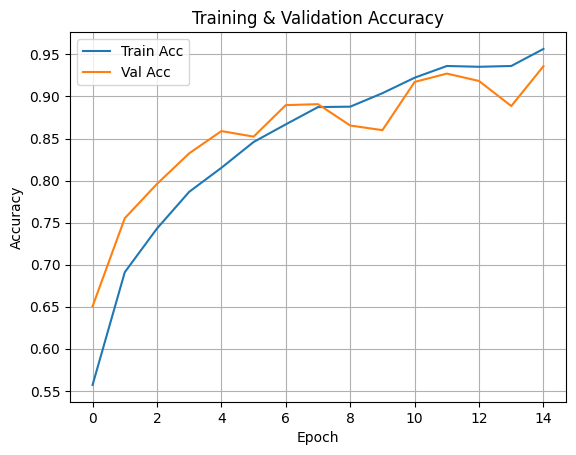

In [ ]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step


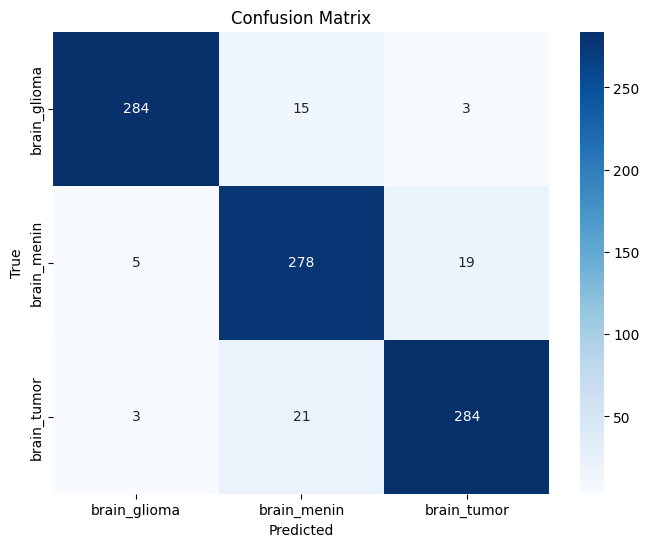

              precision    recall  f1-score   support

brain_glioma       0.97      0.94      0.96       302
 brain_menin       0.89      0.92      0.90       302
 brain_tumor       0.93      0.92      0.93       308

    accuracy                           0.93       912
   macro avg       0.93      0.93      0.93       912
weighted avg       0.93      0.93      0.93       912



In [ ]:
def plot_confusion_matrix(model, test_generator):

    y_true = []
    for images, labels in test_generator:
        y_true.extend(tf.argmax(labels, axis=1).numpy())


    y_pred_prob = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred_prob, axis=1)


    cm = confusion_matrix(y_true, y_pred_classes)


    class_names = test_generator.class_names

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


    print(classification_report(
        y_true, y_pred_classes, target_names=class_names))

plot_confusion_matrix(model, test_generator)

In [1]:
model_test = load_model('best_model.keras')
img_size = (224, 224)

NameError: name 'load_model' is not defined

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image
import io
import traceback
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import softmax
from sklearn.metrics import confusion_matrix, classification_report
import itertools

img_size = (224, 224)

test_uploader = widgets.FileUpload(accept='image/*', multiple=False)
output = widgets.Output()
display(test_uploader, output)

def handle_upload(change):
    with output:
        clear_output(wait=True)
        if test_uploader.value:
            try:
                file_name, file_data = list(test_uploader.value.items())[0]
                img_data = file_data['content']
                img = Image.open(io.BytesIO(img_data)).convert("RGB")
                img_resized = img.resize(img_size)
                plt.figure(figsize=(8, 6))
                plt.imshow(img_resized)
                plt.axis("off")
                plt.show()

                # Pre-processing
                img_array = np.asarray(img_resized) / 255.0
                img_array = np.expand_dims(img_array, axis=0)
                raw_output = model_test.predict(img_array)[0]

                # Cek output dan prediksi
                if np.sum(raw_output) > 0.99 and np.sum(raw_output) <= 1.01:
                    pred_prob = raw_output
                else:
                    pred_prob = softmax(raw_output)

                pred_class = np.argmax(pred_prob)
                confidence = pred_prob[pred_class]
                class_labels = test_generator.class_names

                print(f"Predicted Class: {class_labels[pred_class]}")
                print(f"Confidence: {confidence:.4f}")
            except Exception as e:
                traceback.print_exc()
                print(f"Error processing image: {e}")

test_uploader.observe(handle_upload, names='value')


FileUpload(value={}, accept='image/*', description='Upload')

Output()